In [1]:
%matplotlib inline
from __future__ import division, print_function
import numpy as np
from astropy.table import Table
import matplotlib.pyplot as plt
from scipy import stats
import skgof

In [2]:
def compute_cdf(a, bins):
    """
    Inputs
    ------
    a: 1-D array of elements;
    bins: bins for the CDF;

    Outputs
    -------
    cdf: 1-D array of CDF values in each bin; 
    binedges: edges of the bins;
    binctr: center of the bins;
    """
    hist, binedges = np.histogram(a, bins=bins)
    hist = hist/len(a)
    binctr = (binedges[1:] + binedges[:-1])/2.
    cdf = np.zeros(len(hist))
    cdf[0] = hist[0]
    for cdf_index in range(1, len(hist)):
        cdf[cdf_index] = cdf[cdf_index-1]+hist[cdf_index]
        
    return cdf, binedges, binctr

## QQ plot

--------
## Generate random data for one-sample tests

In [3]:
n = 100
np.random.seed(2942)
a = stats.uniform.rvs(size=n)
# Save to file for verification in R
t = Table()
t['x'] = a
t.write('../test/t.dat', format='csv', overwrite=True)

------
## Cramer-von Mises one-sample

In [36]:
def cmv_approx(n, x, y, yt):
    '''
    Calculate approximate Cramer-von Mises statistic using ECDF;
    n: sample size;
    x: array of the grid; 
    y: array of gridded CDF values of the sample;
    yt: array of gridded CDF values of theoretical distribution;
    '''
    cmv = n * np.sum(((y - yt)[:-1])**2*(yt[1:]-yt[:-1]))
    return cmv

In [47]:
bins = np.linspace(-2, 2, int(1e6))
cdf, _, binctr = compute_cdf(a, bins=bins)

rv = stats.uniform()
cdf_theory = rv.cdf(binctr)

cmv_approx(n, binctr, cdf, cdf_theory)

0.17270146920102905

In [50]:
# Veriy with scikit-gof
skgof.cvm_test(a, stats.uniform())

GofResult(statistic=0.1727140499927575, pvalue=0.32758043193335817)

__Run the following code on R to verify the results:__

```
library(goftest)
t = read.table('/Users/roz18/git/PZDC1paper/test/t.dat', header=T, sep=',')
cvm.test(t$x, "punif")
```

__Results:__

```
	Cramer-von Mises test of goodness-of-fit
	Null hypothesis: uniform distribution

data:  t$x
omega2 = 0.17271, p-value = 0.3276
```

__My code, scikit-gof and R all give consistent results. Since scikit-gof is readily available, I should use it for the paper. __

------
## Anderson-Darling one-sample

In [4]:
def ad_approx(n, x, y, yt):
    '''
    Calculate approximate Anderson-Darling statistic using ECDF;
    n: sample size;
    x: array of the grid; 
    y: array of gridded CDF values of the sample;
    yt: array of gridded CDF values of theoretical distribution;
    '''
    # compute Anderson-Darling statistic
    inv_weight = (yt*(1-yt))[:-1]
    # remove infinities in the weight function
    mask = (inv_weight<1e-5)
    inv_weight[mask] = 1
    ads = n * np.sum(((y - yt)[:-1])**2*(yt[1:]-yt[:-1])/inv_weight)
    return ads

In [7]:
n = 100
bins = np.linspace(0, 1., int(1e6))
cdf, _, binctr = compute_cdf(a, bins=bins)

rv = stats.uniform()
cdf_theory = rv.cdf(binctr)

ad_approx(n, binctr, cdf, cdf_theory)

0.94131840451869031

In [9]:
# Veriy with scikit-gof
skgof.ad_test(a, stats.uniform())

GofResult(statistic=0.94132320139797798, pvalue=0.38934565117409048)

__Run the following code on R to verify the results:__

```
library(goftest)
t = read.table('/Users/roz18/git/PZDC1paper/test/t.dat', header=T, sep=',')
ad.test(t$x, "punif")
```

__Results:__

```
	Anderson-Darling test of goodness-of-fit
	Null hypothesis: uniform distribution

data:  t$x
An = 0.94132, p-value = 0.3893
```

__My code, scikit-gof and R all give consistent results. Since scikit-gof is readily available, I should use it for the paper. Scipy have Anderson-Darling but does not support uniform distribution, and gives wrong answers for normal distribution. __

---------
## Kolmogorov-Smirnov one-sample

In [72]:
# scikit-gof
skgof.ks_test(a, stats.uniform())

GofResult(statistic=0.10006007833671571, pvalue=0.25207814336923806)

In [71]:
# Scipy
scipy.stats.kstest(a, 'uniform')

KstestResult(statistic=0.10006007833671571, pvalue=0.25256187855309919)

------
## Anderson Darling two-sample

In [8]:
def ad_2samp_approx(n1, n2, y1, y2):
    '''
    Calculate approximate Anderson-Darling statistic from two CDFs;
    n1, n2: sample size of the two distribution2;
    y1, y2: arrays of gridded CDF values of the two distributions;
    '''
    n = n1+n2
    h = (n1*y1+n2*y2)/n
    # compute Anderson-Darling statistic
    inv_weight = (h*(1-h))[:-1]
    # remove infinities in the weight function
    mask = (inv_weight<1e-5)
    inv_weight[mask] = 1
    ads = n1*n2/n * np.sum(((y2 - y1)[:-1])**2*(h[1:]-h[:-1])/inv_weight)
    return ads

def ad_2samp_exact(a1, a2):
    '''
    Calculate exact Anderson-Darling statistic of two samples;
    a1, a2: arrays of elements of the two distributions;
    '''

    n1, n2 = len(a1), len(a2)
    n = n1 + n2
    z = np.sort(np.concatenate([a1, a2]))
    
    sum1 = sum2 = 0
    for j in range(1, n):
        m1j = np.sum(a1<=z[j-1])
        m2j = np.sum(a2<=z[j-1])
        sum1 += (n*m1j - j*n1)**2/(j*(n-j))
        sum2 += (n*m2j - j*n2)**2/(j*(n-j))
    
    # print(sum1)
    # print(sum2)
    # It seems that sum1 and sum2 are the same
    
    return 1/n*(1/n1*sum1+1/n2*sum2)

In [9]:
n1 = 100
n2 = 50

np.random.seed(2942)
a1 = np.random.randn(n1)+0.1
a2 = np.random.randn(n2)

bins = np.linspace(-5, 5, int(5e5))
cdf1, _, binctr = compute_cdf(a1, bins=bins)
cdf2, _, binctr = compute_cdf(a2, bins=bins)

In [10]:
print('Approximate solution: ')
print(ad_2samp_approx(n1, n2, cdf1, cdf2))

Approximate solution: 
0.865540684482


In [11]:
print('Exact solution: ')
print(ad_2samp_exact(a1, a2))

Exact solution: 
0.865540684482


__Note that the exact method might not work when there are ties, especially if a1 and a2 are the same.__ 

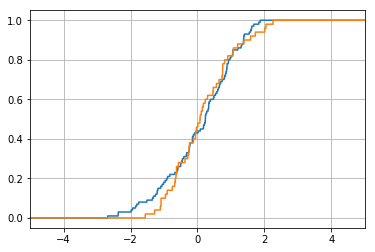

In [12]:
plt.plot(binctr, cdf1)
plt.plot(binctr, cdf2)
plt.xlim(-5,5)
plt.grid()
plt.show()

In [13]:
# Verify on R
t1 = Table()
t2 = Table()
t1['x'] = a1
t2['x'] = a2
t1.write('../test/t1.dat', format='csv', overwrite=True)
t2.write('../test/t2.dat', format='csv', overwrite=True)

__Run the following code on R to verify the results:__

```
library(kSamples)
t1 = read.table('/Users/roz18/git/PZDC1paper/test/t1.dat', header=T, sep=',')
t2 = read.table('/Users/roz18/git/PZDC1paper/test/t2.dat', header=T, sep=',')
ad.test(t1$x, t2$x)
```

__Results:__

```
 Anderson-Darling k-sample test.

Number of samples:  2
Sample sizes:  100, 50
Number of ties: 0

Mean of  Anderson-Darling  Criterion: 1
Standard deviation of  Anderson-Darling  Criterion: 0.75206

T.AD = ( Anderson-Darling  Criterion - mean)/sigma

Null Hypothesis: All samples come from a common population.

               AD    T.AD  asympt. P-value
version 1: 0.8655 -0.1788           0.4368
version 2: 0.8830 -0.1559           0.4256
```

__Again Scipy gives a wrong answer (this time a nonsensical negative value):__

In [208]:
scipy.stats.anderson_ksamp([a1, a2])

Anderson_ksampResult(statistic=-0.15593449583593094, critical_values=array([ 0.325,  1.226,  1.961,  2.718,  3.752]), significance_level=0.40969005738378117)

--------------

In [63]:
import statsmodels.api as sm

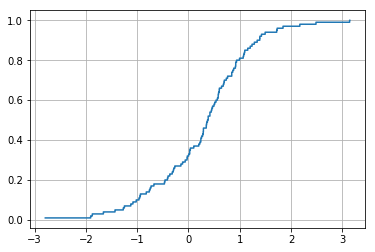

In [64]:
n1 = 100
n2 = 50

np.random.seed(2112)
a1 = np.random.randn(n1)+0.1
a2 = np.random.randn(n2)
ecdf1 = sm.distributions.ECDF(a1)
ecdf2 = sm.distributions.ECDF(a2)

x = np.linspace(min(a1), max(a1), 10000)
y = ecdf1(x)
plt.step(x, y)
plt.grid()
plt.show()

-------------

## Kolmogorov-Smirnov Test

In [192]:
def ks_2smp(y1, y2):
    '''
    Calculate approximate Kolmogorov-Smirnov statistic from two CDFs;
    y1, y2: arrays of gridded CDF values of the two distributions;
    '''
    return np.max(np.abs(y1-y2))

In [188]:
ks_2samp(cdf1, cdf2)

0.26000000000000012

In [194]:
scipy.stats.ks_2samp(a1, a2)

Ks_2sampResult(statistic=0.26000000000000001, pvalue=0.01771724231168605)